# Astropy learning notebook
******

In [2]:
import astropy
import numpy as np
import matplotlib.pyplot as plt 

## Data structures and transformations
---

### Astropy Constants

In [3]:
from astropy import constants as const
from astropy import units as u

#constants
print("G:",const.G)
print("N_A:",const.N_A)

#units convert
print(const.c.to('km/s'))
print(const.c.to('pc/yr')) 

#in conjunction with units and other non-const quantity
F = (const.G * 3. * const.M_sun * 100 * u.kg)/(2.2 * u.au )**2
print(F.to(u.N))

const.c.cgs # Centimeter-Gram-Second (CGS) units 

G:   Name   = Gravitational constant
  Value  = 6.6743e-11
  Uncertainty  = 1.5e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2018
N_A:   Name   = Avogadro's number
  Value  = 6.02214076e+23
  Uncertainty  = 0.0
  Unit  = 1 / mol
  Reference = CODATA 2018
299792.458 km / s
0.3066013937879528 pc / yr
0.3675671602160826 N


<Quantity 2.99792458e+10 cm / s>

### Units and Quantities

In [4]:
from astropy import units as u
from astropy.units import imperial
import numpy as np

#create a Quantity 
print(42.0 * u.meter)  
print([1., 2., 3.] * u.m)  
print(np.array([1.,2.,3.])*u.m)

#unit and value from a Quantity
q = 42.0 * u.meter
print(q.value,"\n",q.unit)

#Quantity combine
print(15.1 * u.meter / (32.0 * u.second)) 
print(3.0 * u.kilometer / (130.51 * u.meter / u.second) )

#directly work with units
cms = u.cm/u.s
mph = imperial.mile / u.hour
q = 42.0 * cms
q.to(mph)

#dimensionless
print(u.m/u.m)

#equivalencies between wavelength and frequency
#(1000 * u.nm).to(u.Hz)
(1000 * u.nm).to(u.Hz, equivalencies=u.spectral())  

42.0 m
[1. 2. 3.] m
[1. 2. 3.] m
42.0 
 m
0.471875 m / s
0.022986744310780783 km s / m



<Quantity 2.99792458e+14 Hz>

### N-Dimensional Datasets

In [5]:
import numpy as np
from astropy.modeling.models import Gaussian2D

#create some data (a few guassian sources and a cosmic ray)
y,x = np.mgrid[0:500 , 0:600]
data = (Gaussian2D(1,150,100,20,10,theta=0.5)(x,y)+
        Gaussian2D(0.5,400,300,8,12,theta=1.2)(x,y)+
        Gaussian2D(0.75,250,400,5,7,theta=0.23)(x,y)+
        Gaussian2D(0.9,525,150,3,3)(x,y)+
        Gaussian2D(0.6,200,225,3,3)(x,y)
       )
data += 0.01 * np.random.randn(500,600)
cosmic_ray_value = 0.997
data[100,300:310] = cosmic_ray_value

#create mask
mask = (data == cosmic_ray_value)

In [6]:
#CCDdata
from astropy.nddata import CCDData

#ccd construtor, write and read
ccd = CCDData(data,mask=mask,
             meta={'object':'fake galaxy','filter':'R'},
             unit='adu')
#ccd.write('test.fits', overwrite=True)
ccd2 = CCDData.read('test.fits')
#CCDData.read.help('fits')
#CCDData.write.help('fits')

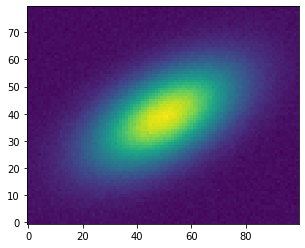

In [7]:
#Cutout2D
from astropy.nddata import Cutout2D

#cutout a region
position = (149.7 , 100.1)
size = (80,100) #pixels
cutout = Cutout2D(ccd,position,size)
plt.imshow(cutout.data, origin='lower')

(149.7, 100.1) (49.69999999999999, 39.099999999999994)


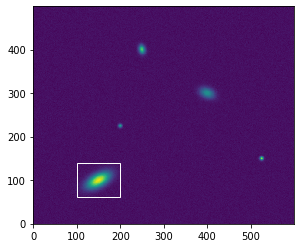

In [8]:
#plot on the original image
plt.imshow(ccd,origin='lower')
cutout.plot_on_original(color = 'white')

#original pixel coordinates and those in the cutout 
print(position,cutout.to_cutout_position(position))

In [ ]:
#crop fits image keeping WCS
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
import datetime

# Read fits file.
hdulist = fits.open('ds9.fits')
hdu = hdulist[0].data
# Header
hdr = hdulist[0].header
hdulist.close()

# Some center and box to crop
xc, yc, xbox, ybox = 4300., 4300., 5000., 5000

#method of using Cutout2D
# Crop image
hdu_crop = Cutout2D(hdu, (xc, yc), (xbox, ybox), wcs=WCS(hdr))
# Cropped WCS
wcs_cropped = hdu_crop.wcs
# Update WCS in header
hdr.update(wcs_cropped.to_header())
# Add comment to header
hdr['COMMENT'] = "= Cropped fits file ({}).".format(datetime.date.today())
# Write cropped frame to new fits file.
fits.writeto('crop.fits', hdu_crop.data, hdr)

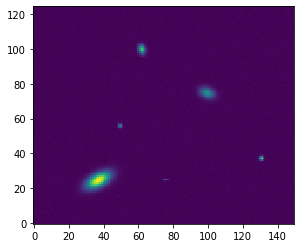

In [26]:
#reduce the image size
from astropy.nddata.utils import block_reduce

smaller = block_reduce(ccd,4)
smaller 
plt.imshow(smaller,origin='lower')

## Files, I/O, and Communication
---

In [30]:
#I/O of tabular data
from astropy.table import Table

t = Table.read('rSDSS.cat',format='ascii.sextractor')
#print(t)

In [56]:
#FITs files
from astropy.io import fits

#open fits image
hdulist = fits.open('test.fits')

#something useful
hdulist.info()
header = hdulist[0].header
data = hdulist[1].data
print(header)

print(data.shape,data.dtype.name)

#close fits image
hdulist.close()

Filename: test.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (600, 500)   float64   
  1  MASK          1 ImageHDU         8   (600, 500)   uint8   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  600                                                  NAXIS2  =                  500                                                  EXTEND  =                    T                                                  OBJECT  = 'fake galaxy'                                                         FILTER  = 'R       '                                                            BUNIT   = 'adu     '                                                            END                                                                 

In [ ]:
#writeto function
n = np.arange(100.0)
hdu = fits.PrimaryHDU(n)
hdulist = fits.HDUList([hdu])
hdulist.writeto('new.fits', overwrite=True)
#hdu.writeto('new.fits', overwrite=True)

Filename: C:\Users\DELL\.astropy\cache\download\py3\2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   
<class 'numpy.ndarray'>
(893, 891)


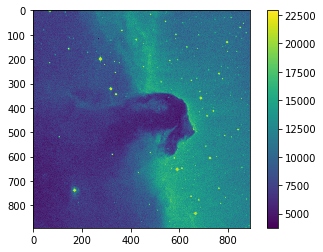

In [69]:
#show a FITs image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
path = 'http://data.astropy.org/tutorials/FITS-images/HorseHead.fits'
image_file = download_file(path, cache=True)
hdu_list = fits.open(image_file2)
hdu_list.info()
 
image_data = hdu_list[0].data   #此处是hdu_list[0].data，不是hdu_list[1].data
hdu_list.close()
 
image_data = fits.getdata(image_file)
print(type(image_data))
print(image_data.shape)
 
plt.imshow(image_data)
plt.colorbar()
plt.show()
